In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf

2023-05-30 23:00:46.641070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf. __version__)

2.11.0


In [3]:
dev = qml.device('default.mixed', wires=3)

In [4]:
def real():
    qml.Rot( 0.0,np.pi/2, np.pi/6,wires=0)

In [5]:
print(qml.draw(real)())

0: ──Rot(0.00,1.57,0.52)─┤  


In [6]:
p = 0
def generator(w,**kwargs):
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=1)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=1)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RX(w[6], wires=0)
    qml.RY(w[7], wires=0)
    qml.RZ(w[8], wires=0)
    qml.Rot(0.0, np.pi/2, -np.pi/6,wires=0)
    #qml.BitFlip(p, wires=0)
    #qml.BitFlip(p, wires=1)

In [7]:
print(qml.draw(generator)([ 0,0,0,0,0,0,0,0,0]))

0: ──RX(0.00)──RY(0.00)──RZ(0.00)─╭●──RX(0.00)──RY(0.00)──RZ(0.00)──Rot(0.00,1.57,-0.52)─┤  
1: ──RX(0.00)──RY(0.00)──RZ(0.00)─╰X─────────────────────────────────────────────────────┤  


In [8]:
def discriminator(w):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=2)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=2)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=2)
    qml.CNOT(wires=[0, 2])
    qml.RX(w[6], wires=2)
    qml.RY(w[7], wires=2)
    qml.RZ(w[8], wires=2)
    #qml.BitFlip(p, wires=0)
    #qml.BitFlip(p, wires=2)

In [9]:
print(qml.draw(discriminator)([ 0,1,2,3,4,5,6,7,8]))

0: ──H─────────RX(0.00)──RY(2.00)──RZ(4.00)─╭●───────────────────────────────┤  
2: ──RX(1.00)──RY(3.00)──RZ(5.00)───────────╰X──RX(6.00)──RY(7.00)──RZ(8.00)─┤  


In [10]:
@qml.qnode(dev, interface='tf')
def real_disc_circuit(disc_weights):
    real()
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

@qml.qnode(dev,interface='tf')
def gen_disc_circuit(gen_weights,disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

In [11]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(disc_weights)
    #convert to probability
    prob_real_true = (true_disc_output+1)/2
    return prob_real_true

In [12]:
def prob_fake_true(gen_weights,disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights,disc_weights)
    #convert to probability
    prob_fake_true = (fake_disc_output+1)/2
    return prob_fake_true

In [13]:
def disc_cost(disc_weights):
    cost = prob_fake_true(gen_weights,disc_weights)-prob_real_true(disc_weights)
    return cost
def gen_cost(gen_weights):
    cost = -prob_fake_true(gen_weights,disc_weights)
    return cost

In [16]:
np.random.seed(0)
eps = 1e-2
#init_gen_weights = np.array([np.pi] + [0] * 8) + \
                   #np.random.normal(scale=eps, size=(9,))
    
init_gen_weights = np.array([0]*9)
init_disc_weights = np.random.normal(size=(9,))
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)

In [17]:
print(init_gen_weights)

[0 0 0 0 0 0 0 0 0]


In [18]:
loss_val_d = []
loss_val_g = []
step_d = []
step_g = []

In [38]:
opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.4)

var = disc_weights
print('var =',var)

loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
print('loss =',disc_cost(disc_weights) )

for step in range(50):
    opt.minimize(loss, [var])
    if step % 5 == 0:
        loss_val = loss().numpy()
        loss_val_d.append(loss_val)
        step_d.append(step)
        print("Step {}: cost = {}".format(step, loss_val))

var = <tf.Variable 'Variable:0' shape=(9,) dtype=float64, numpy=
array([ 3.66516414e+00,  4.44080770e-01, -1.61395804e-05,  2.26235436e+00,
        1.86755799e+00, -1.01747319e+00,  9.57114639e-01, -2.44630251e-10,
       -1.03218852e-01])>
loss = tf.Tensor(0.24998818365144104, shape=(), dtype=float64)
Step 0: cost = 0.17163513979406908
Step 5: cost = -0.286813269367878
Step 10: cost = -0.47019655491345286
Step 15: cost = -0.4966560585248493
Step 20: cost = -0.49960643063082005
Step 25: cost = -0.4999245921434945
Step 30: cost = -0.4999587759812294
Step 35: cost = -0.49996244729887057
Step 40: cost = -0.4999628415787576
Step 45: cost = -0.4999628839221162


In [39]:
opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
var_g = gen_weights
print('var_g =',var_g)

loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
print('loss =',gen_cost(gen_weights))

for step in range(50):
    opt.minimize(loss, [var_g])
    if step % 5 == 0:
        loss_val = loss().numpy()
        loss_val_g.append(loss_val)
        step_g.append(step)
        print("Step {}: cost = {}".format(step, loss_val))

var_g = <tf.Variable 'Variable:0' shape=(9,) dtype=float64, numpy=
array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -8.57032658e-05,  1.61369448e-05,
       -6.56114552e-06])>
loss = tf.Tensor(-0.2500438781915403, shape=(), dtype=float64)
Step 0: cost = -0.3284185431517026
Step 5: cost = -0.7869166085277126
Step 10: cost = -0.9702513955689802
Step 15: cost = -0.9966958234394534
Step 20: cost = -0.9996438948843904
Step 25: cost = -0.9999617481952865
Step 30: cost = -0.99999589256729
Step 35: cost = -0.9999995589657511
Step 40: cost = -0.9999999526442863
Step 45: cost = -0.9999999949152188


In [40]:
loss_d = [ -x for x in loss_val_d]

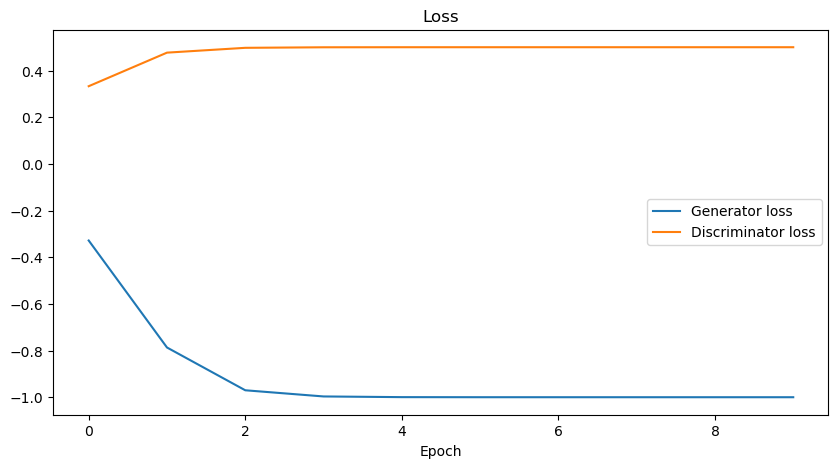

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), loss_val_g, label="Generator loss")
plt.plot(range(len(step_d)), loss_d, label="Discriminator loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

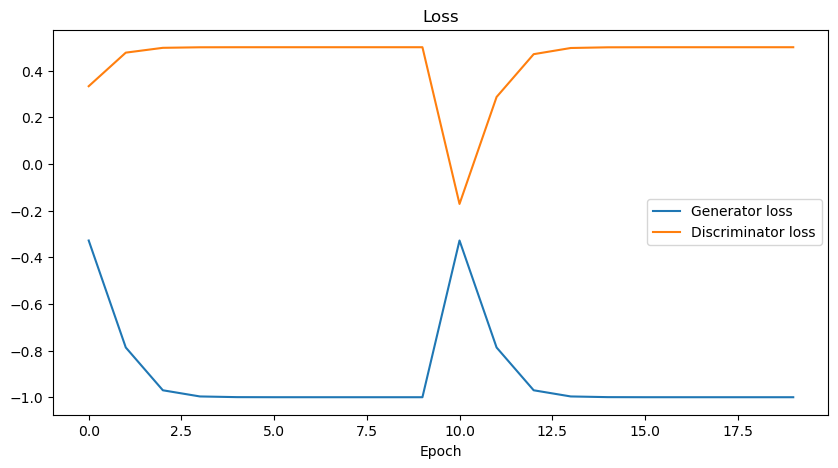

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), loss_val_g, label="Generator loss")
plt.plot(range(len(step_d)), loss_d, label="Discriminator loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

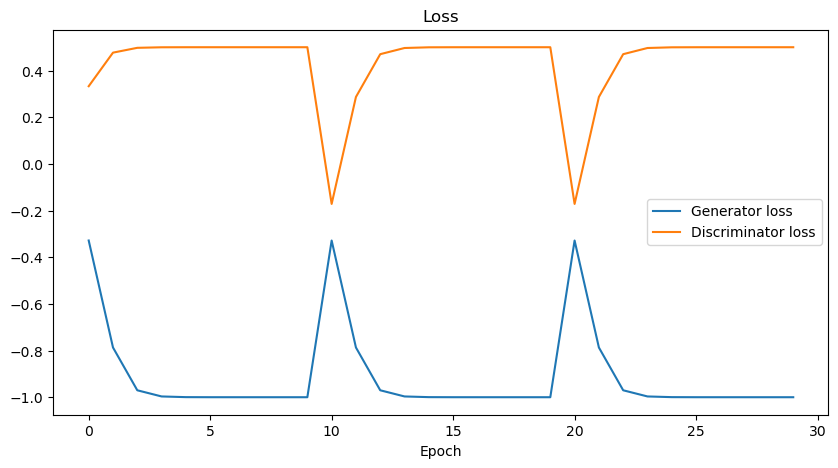

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), loss_val_g, label="Generator loss")
plt.plot(range(len(step_d)), loss_d, label="Discriminator loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()